Base on https://www.kaggle.com/artgor/quick-and-dirty-regression @artgor

Please upvote the original kernel, thanks. 👋

## Importing libraries

In [15]:
import altair as alt
from bayes_opt import BayesianOptimization
import catboost as cat
from catboost import CatBoostRegressor
from category_encoders.ordinal import OrdinalEncoder
from collections import Counter
from collections import defaultdict
import datetime
import eli5
from functools import partial
import gc
from IPython.display import HTML
from itertools import product
from joblib import Parallel, delayed
import json
import lightgbm as lgb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit
import numpy as np
import os
import pandas as pd
from random import choice
import re
import seaborn as sns
import scipy as sp
from scipy import stats
import shap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import tensorflow as tf
from time import time
from tqdm import tqdm_notebook as tqdm
from typing import List, Any
import warnings
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier, XGBRegressor

np.random.seed(566)
sns.set(style='darkgrid')
warnings.filterwarnings("ignore")

## Helper functions and classes

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True

In [4]:
def read_data():
    base_path = '/kaggle/input/data-science-bowl-2019' if not local else '../input'
    
    print('Reading train.csv file....')
    train = pd.read_csv(os.path.join(base_path, 'train.csv'))
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(os.path.join(base_path, 'test.csv'))
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(os.path.join(base_path, 'specs.csv'))
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = [str(title) + '_' + str(event_code) for title, event_code in zip(train['title'] ,train['event_code'])]
    test['title_event_code'] = [str(title) + '_' + str(event_code) for title, event_code in zip(test['title'] ,test['event_code'])]
#     train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
#     test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))

    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
#     assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].unique()) & set(test[test['type'] == 'Assessment']['title'].unique()))
    
    for data in [all_title_event_code, list_of_user_activities, list_of_event_code, list_of_event_id, list_of_worlds]:
        data.sort()
    
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map

def get_data(user_sample, test_set=False):
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    clip_count = {'0_Clip': 0, '1_Clip': 0, '2_Clip': 0, '3_Clip': 0} # by session
    accumu_clip_count = {'0_Clip_accumu': 0, '1_Clip_accumu': 0, '2_Clip_accumu': 0, '3_Clip_accumu': 0} # by installation id
    Activity_by_world = {'0_Activity_accumu': 0, '1_Activity_accumu': 0, '2_Activity_accumu': 0, '3_Activity_accumu': 0}
    Game_by_world = {'0_Game_accumu': 0, '1_Game_accumu': 0, '2_Game_accumu': 0, '3_Game_accumu': 0}
    Assessment_experience = {str(k) + '_experience': 0 for k in degree_of_difficulty.keys()}
    Assessment_pass = {str(k) + '_pass': 0 for k in degree_of_difficulty.keys()}
    
    # new features: time spent in each activity
    Game_by_Assessment = 0
    Activity_by_Assessment = 0
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    accumulated_diff_of_difficulty = []
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    install_datetime = user_sample.sort_values('timestamp').iloc[0, 2]
    install_time = user_sample.sort_values('timestamp').iloc[0, 2].timestamp()
    continuous_login_date = 0
    continuous_login_within_3days = 0
    continuous_login_within_7days = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if (install_datetime - session['timestamp'].iloc[0]).days == 1:
            continuous_login_date += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 1:
            continuous_login_date = 0
        
        if ((install_datetime - session['timestamp'].iloc[0]).days > 0) & ((install_datetime - session['timestamp'].iloc[0]).days <= 3):
            continuous_login_within_3days += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 3:
            continuous_login_within_3days = 0
            
        if ((install_datetime - session['timestamp'].iloc[0]).days > 0) & ((install_datetime - session['timestamp'].iloc[0]).days <= 7):
            continuous_login_within_7days += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 7:
            continuous_login_within_7days = 0
        
        if (session_type == 'Clip') & (session['world'] is not None):
            clip_count[str(session['world'].iloc[0]) + '_Clip'] +=1
            accumu_clip_count[str(session['world'].iloc[0]) + '_Clip_accumu'] += 1
        if (session_type == 'Activity') & (len(session)>1):
            act_time = session['timestamp'].iloc[-1].timestamp() - session['timestamp'].iloc[0].timestamp()
            Activity_by_Assessment += act_time
            Activity_by_world[str(session['world'].iloc[0]) + '_Activity_accumu'] += act_time
            
        if (session_type == 'Game') & (len(session)>1):
            game_time = session['timestamp'].iloc[-1].timestamp() - session['timestamp'].iloc[0].timestamp()
            Game_by_Assessment += game_time
            Game_by_world[str(session['world'].iloc[0]) + '_Game_accumu'] += game_time
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(clip_count.copy())
            features.update(accumu_clip_count.copy())
            features.update(Game_by_world.copy())
            features.update(Activity_by_world.copy())

            clip_count = {'0_Clip': 0, '1_Clip': 0, '2_Clip': 0, '3_Clip': 0}
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            features['diff_install_time'] = install_time - session.iloc[0, 2].timestamp()
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            if accumulated_diff_of_difficulty == []:
                features['accumulated_diff_of_difficulty'] = None
            else:
                features['accumulated_diff_of_difficulty'] = np.sum(accumulated_diff_of_difficulty)
                
            accumulated_diff_of_difficulty.append(features['accuracy_group'] - degree_of_difficulty[features['session_title']])
            
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            features.update(Assessment_experience)
            Assessment_experience[str(session['title'].iloc[0]) + '_experience'] += 1
            features.update(Assessment_pass)
            if true_attempts > 0:
                Assessment_pass[str(session['title'].iloc[0]) + '_pass'] += 1
            
            features['timestamp'] = session['timestamp'].iloc[-1]
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            features['sum_Activity_by_Assessment'] = Activity_by_Assessment
            Activity_by_Assessment = 0
            features['sum_Game_by_Assessment'] = Game_by_Assessment
            Game_by_Assessment = 0
            
            features['continuous_login_date'] = continuous_login_date
            features['continuous_login_within_3days'] = continuous_login_within_3days
            features['continuous_login_within_7days'] = continuous_login_within_7days
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1], all_assessments[:-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data, train_data_in_test = get_data(user_sample, test_set = True)
        compiled_train += train_data_in_test
        compiled_test.append(test_data)

    reduce_train, reduce_test = pd.DataFrame(compiled_train), pd.DataFrame(compiled_test)
    
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):

    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, ps={}, target='accuracy_group', plot=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = target
        self.cv = self.get_cv()
        self.params = self.set_params(ps)
        self.evals_result = {}
        self.evals_results = []
        self.models = []
        self.random_seed = True
        self.plot = plot
        self.y_pred = self.fit()

    def train_model(self, train_set, val_set):
        raise NotImplementedError

    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits,
                             shuffle=True, random_state=42)

        return cv.split(self.train_df, self.train_df[self.target])

    def set_params(self, ps={}):
        return None if ps == {} else ps

    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))

        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)

            model = self.train_model(train_set, val_set)
            self.models.append(model)
            self.evals_results.append(self.evals_result)
            oof_pred[val_idx] = model.predict(
                x_val).reshape(oof_pred[val_idx].shape)

            x_test = self.test_df[self.features]
            y_pred += model.predict(x_test).reshape(y_pred.shape) / \
                self.n_splits
            self.params['seed'] += 1
        self.oof_pred = oof_pred
        self.score = np.sqrt(mean_squared_error(self.train_df[self.target], self.oof_pred))
        if self.plot:
            self.report_plot()
        return y_pred

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError

    def plot_feature_importance(self, model):
        pass

    def report_plot(self):
        pass


class Lgb_Model(Base_Model):

    def train_model(self, train_set, val_set):
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=100, evals_result=self.evals_result)

    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(
            x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(
            x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set

    def set_params(self, ps):
        params = {'n_estimators': 5000,
                  'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'subsample': 0.75,
                  'subsample_freq': 1,
                  'learning_rate': 0.01,
                  'feature_fraction': 0.9,
                  'max_depth': 15,
                  'lambda_l1': 1,
                  'lambda_l2': 1,
                  'early_stopping_rounds': 100,
                  'seed': 42
                  }

        if not ps == {}:
            for key in ps.keys():
                params[key] = ps[key]
        return params

    def report_plot(self):
        fig, ax = plt.subplots(figsize=(16, 12))
        plt.subplot(2, 2, 1)
        self.plot_feature_importance()
        plt.subplot(2, 2, 2)
        self.plot_metric()
        plt.subplot(2, 2, 3)
        plt.hist(self.train_df[self.target] - self.oof_pred)
        plt.title('Distribution of errors')
        plt.subplot(2, 2, 4)
        plt.hist(self.oof_pred)
        plt.title('Distribution of oof predictions')

    def get_feature_importance(self):
        n = len(self.models)
        feature_imp_df = pd.DataFrame()
        for i in range(n):
            tmp = pd.DataFrame(zip(self.models[i].feature_importance(), self.features), columns=['Value', 'Feature'])
            tmp['n_models'] = i
            feature_imp_df = pd.concat([feature_imp_df, tmp])
            del tmp
        self.feature_importance = feature_imp_df
        return feature_imp_df

    def plot_feature_importance(self, n=20):
        imp_df = self.get_feature_importance().groupby(['Feature'])[['Value']].mean().reset_index(False)
        imp_top20_df = imp_df.sort_values('Value', ascending=False).head(20)
        sns.barplot(data=imp_top20_df, x='Value', y='Feature', orient='h')
        plt.title('Feature importances')

    def plot_metric(self):

        full_evals_results = pd.DataFrame()
        for result in self.evals_results:
            evals_result = pd.DataFrame()
            for k in result.keys():
                evals_result[k] = result[k][self.params['metric']]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.params['metric'], 'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.params['metric'], hue='dataset')
        plt.title('Training progress')


class Wrapper_bayesOpt:

    def __init__(self, train, test, features, categoricals, int_parameters, maximize=True):
        self.train = train
        self.test = test
        self.features = features
        self.categoricals = categoricals
        self.int_parameters = int_parameters
        self.maximize = True

    def LGB_Beyes(self, **kwargs):
        params = {}
        for k in kwargs.keys():
            params[k] = kwargs[k] if not k in self.int_parameters else int(kwargs[k])
        lgb_model = Lgb_Model(self.train, self.test,
                              self.features, categoricals=self.categoricals, ps=params, plot=False)
        score = lgb_model.score if self.maximize else lgb_model.score*-1
        print('score: ', score)
        return lgb_model.score

    def fit(self, bounds_LGB):
        LGB_BO = BayesianOptimization(
            self.LGB_Beyes, bounds_LGB, random_state=1029)
        init_points = 16
        n_iter = 16
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            LGB_BO.maximize(init_points=init_points, n_iter=n_iter,
                            acq='ucb', xi=0.0, alpha=1e-6)
        return LGB_BO

  0%|          | 0/80 [00:00<?, ?it/s]

Build Null Importances distribution


  0%|          | 0/12 [00:00<?, ?it/s]

Start Simulation of feature selection


100%|██████████| 12/12 [09:13<00:00, 46.10s/it]


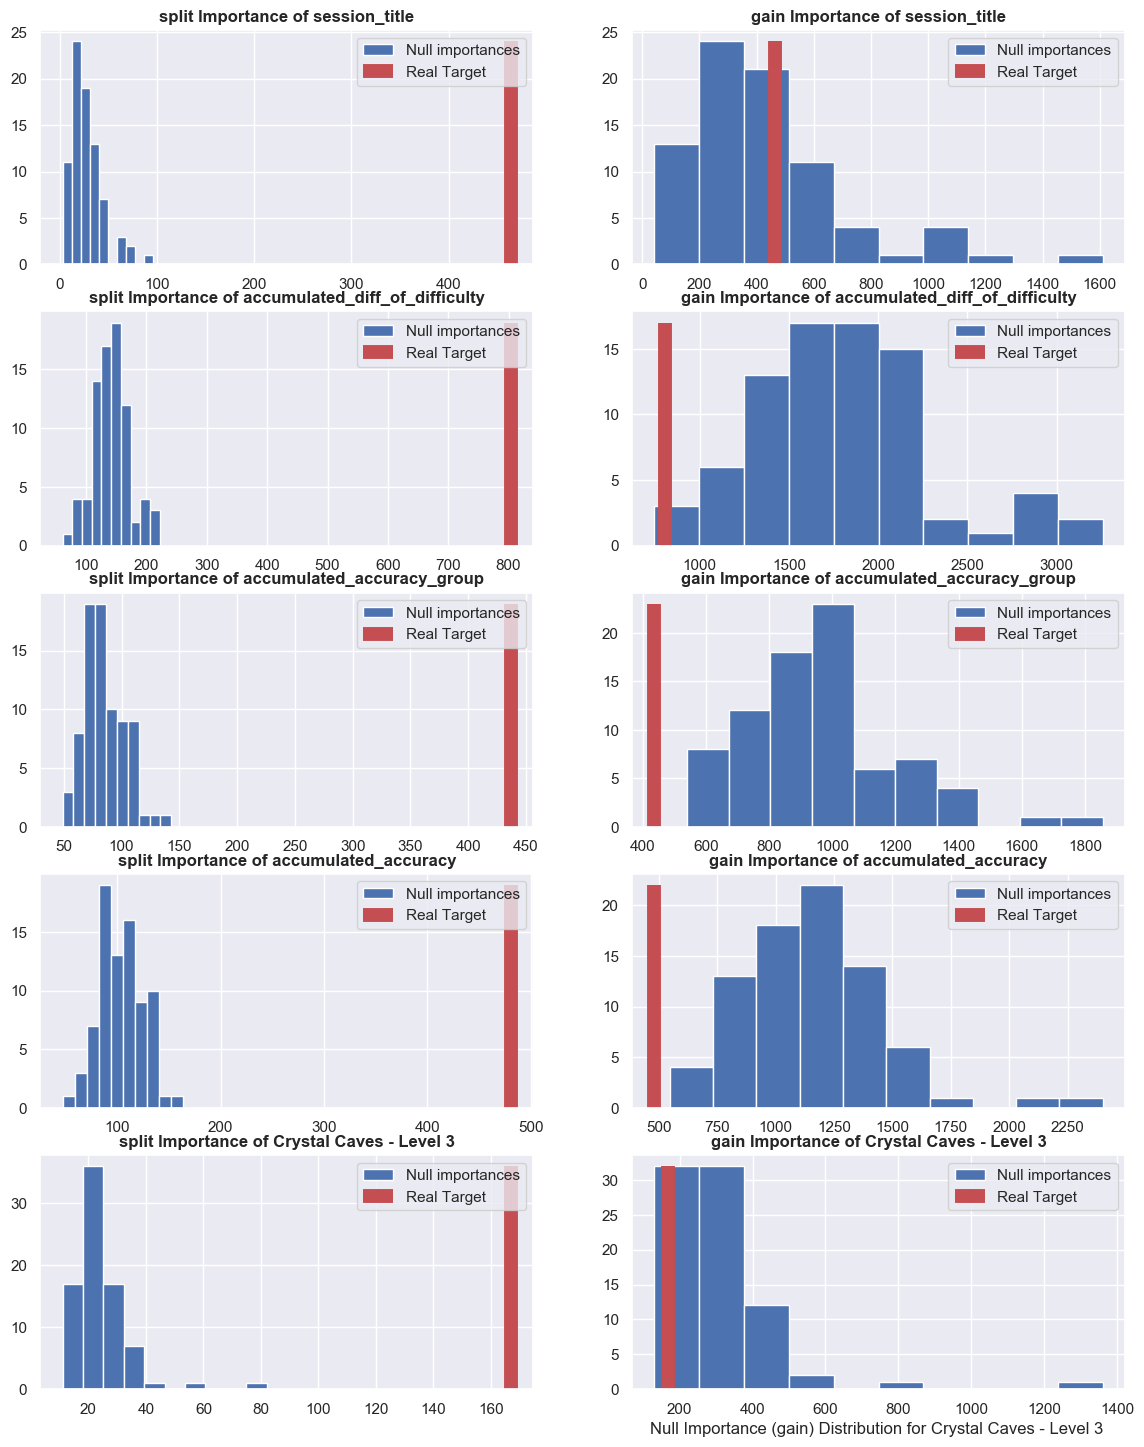

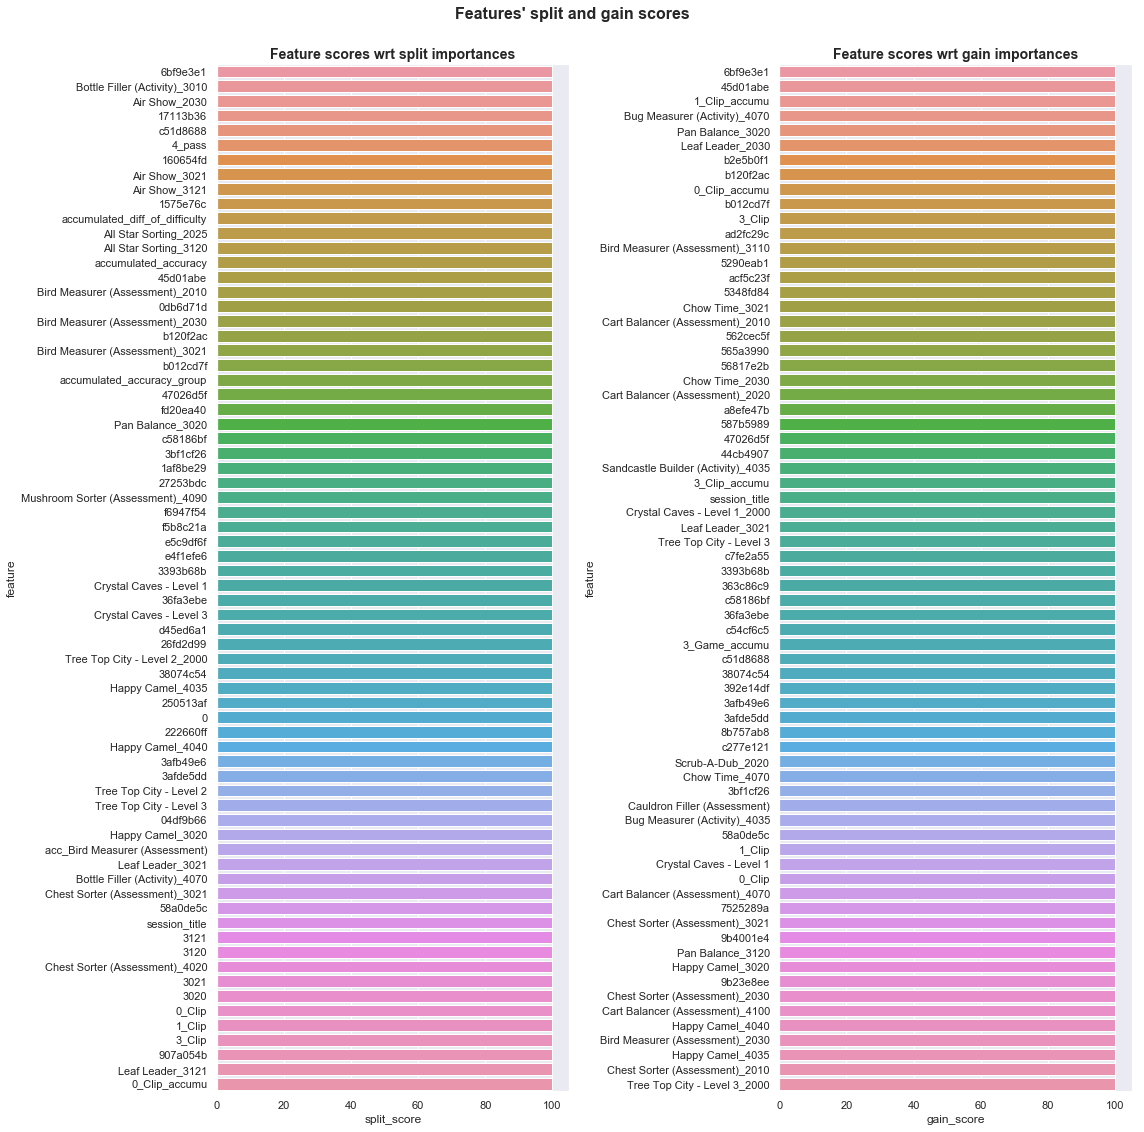

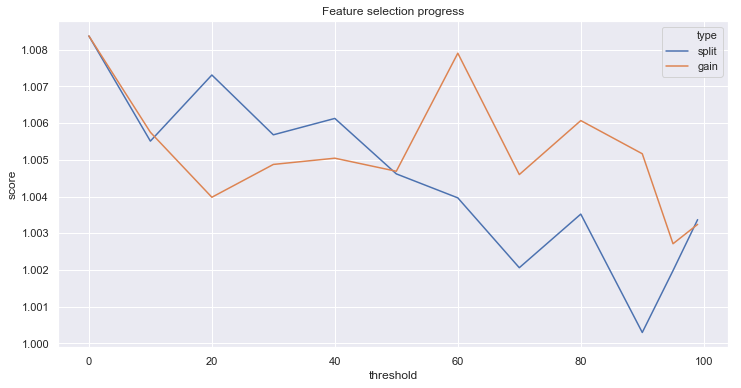

In [9]:
class Null_importance_selecter:

    def __init__(self, train, test, features, categoricals, target='accuracy_group', num_runs=80):
        self.train = train
        self.test = test
        self.features = features
        self.categoricals = categoricals
        self.params = self.set_params()
        self.target = target
        self.num_runs = num_runs
        np.random.seed(123)
        self.fit()

    def fit(self):
        actual_model = self.train_model(shuffle=False)
        self.actual_imp_df = self.get_imp_df(actual_model)

        null_imp_df = pd.DataFrame()
        print('Build Null Importances distribution')
        for i in tqdm(range(self.num_runs)):
            null_model = self.train_model(shuffle=True)
            imp_df = self.get_imp_df(null_model)
            imp_df['run'] = i + 1
            null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
        self.null_imp_df = null_imp_df
        self.display_null_importance_hists()
        self.correlation_scores = self.get_correlation_scores()
        print('Start Simulation of feature selection')
        self.best_score_features = self.score_feature_selection()

    def train_model(self, shuffle=False):

        y = self.train[self.target].copy()
        if shuffle:
            y = self.train[self.target].copy().sample(frac=1.0)
        lgb_train = lgb.Dataset(
            self.train[self.features], y, free_raw_data=False, silent=True)
        model = lgb.train(params=self.params, train_set=lgb_train,
                          num_boost_round=200, categorical_feature=self.categoricals)
        return model

    def get_imp_df(self, lgb_model):
        imp_df = pd.DataFrame()
        imp_df["feature"] = list(self.features)
        imp_df["importance_gain"] = lgb_model.feature_importance(
            importance_type='gain')
        imp_df["importance_split"] = lgb_model.feature_importance(
            importance_type='split')
        return imp_df

    def display_null_importance_hists(self):
        top5_feature = self.actual_imp_df.sort_values(
            ['importance_gain', 'importance_split'], ascending=False)['feature'][:5].reset_index(drop=True)
        fig, axes = plt.subplots(5, 2, figsize=(14, 18), dpi=100)
        for i in range(5):
            self.plot_distributions(top5_feature[i], 'split', axes[i % 5, 0])
            self.plot_distributions(top5_feature[i], 'gain', axes[i % 5, 1])

    def plot_distributions(self, feature, type, ax):
        hist = ax.hist(self.null_imp_df.loc[self.null_imp_df['feature'] == feature, 'importance_{}'.format(
            type)].values, label='Null importances')
        ax.vlines(x=self.actual_imp_df.loc[self.actual_imp_df['feature'] == feature, 'importance_split'].mean(
        ), ymin=0, ymax=np.max(hist[0]), color='r', linewidth=10, label='Real Target')
        ax.legend()
        plt.xlabel(
            'Null Importance ({}) Distribution for {} '.format(type, feature))
        ax.set_title('{} Importance of {}'.format(
            type, feature), fontweight='bold')

    def get_correlation_scores(self):
        correlation_scores = []
        for _f in self.actual_imp_df['feature'].unique():
            f_null_imps = self.null_imp_df.loc[self.null_imp_df['feature']
                                               == _f, 'importance_gain'].values
            f_act_imps = self.actual_imp_df.loc[self.actual_imp_df['feature']
                                                == _f, 'importance_gain'].values
            gain_score = 100 * \
                (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
            f_null_imps = self.null_imp_df.loc[self.null_imp_df['feature']
                                               == _f, 'importance_split'].values
            f_act_imps = self.actual_imp_df.loc[self.actual_imp_df['feature']
                                                == _f, 'importance_split'].values
            split_score = 100 * \
                (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
            correlation_scores.append((_f, split_score, gain_score))
        self.plot_correlation_scores(correlation_scores)
        return correlation_scores

    def plot_correlation_scores(self, correlation_scores):
        corr_scores_df = pd.DataFrame(correlation_scores, columns=[
                                      'feature', 'split_score', 'gain_score'])

        fig = plt.figure(figsize=(16, 16))
        gs = gridspec.GridSpec(1, 2)
        # Plot Split importances
        ax = plt.subplot(gs[0, 0])
        sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values(
            'split_score', ascending=False).iloc[0:70], ax=ax)
        ax.set_title('Feature scores wrt split importances',
                     fontweight='bold', fontsize=14)
        # Plot Gain importances
        ax = plt.subplot(gs[0, 1])
        sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values(
            'gain_score', ascending=False).iloc[0:70], ax=ax)
        ax.set_title('Feature scores wrt gain importances',
                     fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.suptitle("Features' split and gain scores",
                     fontweight='bold', fontsize=16)
        fig.subplots_adjust(top=0.93)

    def score_feature_selection(self):
        results = []
        for threshold in tqdm([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]):
            split_feats, split_cat_feats = self.feature_select_by_threshold(threshold, 'split')
            gain_feats, gain_cat_feats = self.feature_select_by_threshold(threshold, 'gain')

            split_results = self.test_cv(
                train_features=split_feats, train_categoricals=split_cat_feats)
            gain_results = self.test_cv(
                train_features=gain_feats, train_categoricals=gain_cat_feats)
            results.append([threshold, split_results, 'split'])
            results.append([threshold, gain_results, 'gain'])
        selection_results_df = pd.DataFrame(
            results, columns=['threshold', 'score', 'type'])
        self.selection_results = selection_results_df
        self.plot_selection_score()
        condition = selection_results_df.sort_values('score', ascending=False).iloc[0][['threshold', 'type']]
        return self.feature_select_by_threshold(condition['threshold'], condition['type'])

    def feature_select_by_threshold(self, threshold, type):
        if type == 'split':
            feats = [_f for _f, _score, _ in self.correlation_scores if _score >= threshold]
            cat_feats = [_f for _f in feats if _f in self.categoricals]
        else:
            feats = [_f for _f, _, _score in self.correlation_scores if _score >= threshold]
            cat_feats = [_f for _f in feats if _f in self.categoricals]
        return feats, cat_feats

    def test_cv(self, train_features, train_categoricals):
        lgb_train = lgb.Dataset(
            self.train[train_features], self.train[self.target], free_raw_data=False, silent=True)
        hist = lgb.cv(
            params=self.set_params(rf=False),
            train_set=lgb_train,
            num_boost_round=2000,
            categorical_feature=train_categoricals,
            nfold=5,
            stratified=True,
            shuffle=True,
            early_stopping_rounds=50,
            verbose_eval=0,
            seed=17
        )
        return hist['rmse-mean'][-1]

    def plot_selection_score(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(data=self.selection_results,
                     x='threshold', y='score', hue='type')
        plt.title('Feature selection progress')

    def set_params(self, rf=True):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'rf',
            'subsample': 0.75,
            'colsample_bytree': 0.7,
            'num_leaves': 100,
            'max_depth': 8,
            'seed': 42,
            'bagging_freq': 1,
            'n_jobs': 4}
        if not rf:
            params['boosting_type'] = 'gbdt'
        return params


# categoricals = ['session_title']
# features = [col for col in reduce_train.columns if not col in ('game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate')]
# null_imp = Null_importance_selecter(reduce_train, reduce_test, features, categoricals, num_runs=80)

In [35]:
class OptimizedKappaRounder():

    def __init__(self, train_predict_value, train_target_value, label):
        self.train_predict_value = train_predict_value
        self.train_target_value = train_target_value
        self.label = label
        self.coef = self.fit()

    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                       [np.inf], labels=self.label)
        return -cohen_kappa_score(y, preds, weights='quadratic')

    def fit(self):
        loss_partial = partial(
            self._kappa_loss, X=self.train_predict_value, y=self.train_target_value)
        initial_coef = [i + 0.5for i in self.label][:-1]
        return sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X):
        preds = pd.cut(X, [-np.inf] + list(np.sort(self.coef['x'])) +
                       [np.inf], labels=self.label)
        return preds

In [5]:
local = False # when you upload this kernel, please set False 

# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map = encode_title(train, test, train_labels)

assessment_mean = {'Cart Balancer (Assessment)': 2.3004095398699107,
                     'Bird Measurer (Assessment)': 1.3237436270939549,
                     'Chest Sorter (Assessment)': 0.8383092921838309,
                     'Cauldron Filler (Assessment)': 2.306781750924784,
                     'Mushroom Sorter (Assessment)': 2.2142667021559754} # reduce_train.groupby(['session_title'])['accuracy_group'].mean()
degree_of_difficulty = {}
for k, v in assessment_mean.items():
    key = activities_map[k]
    degree_of_difficulty[key] = v

# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]


In [9]:
features = ['Assessment', 'Clip', 'Game', 2000, 2010, 2020, 2030, 2035, 2080, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 5000, '0086365d', '00c73085', '022b4259', '02a42007', '0330ab6a', '0413e89d', '04df9b66', '070a5291', '08fd73f3', '0a08139c', '0d18d96c', '0d1da71f', '0db6d71d', '1325467d', '1375ccb7', '14de4c5d', '155f62a4', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '160654fd', '17113b36', '19967db1', '1996c610', '1af8be29', '1bb5fbdb', '1beb320a', '1c178d24', '1cc7cfca', '1cf54632', '222660ff', '250513af', '25fa8af4', '262136f4', '26fd2d99', '27253bdc', '28a4eb9a', '28f975ea', '29bdd9ba', '29f54413', '2b058fe3', '2dcad279', '30614231', '31973d56', '3323d7e9', '33505eae', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37db1c2f', '37ee8496', '38074c54', '392e14df', '3afb49e6', '3afde5dd', '3b2048ee', '3bf1cf26', '3bfd1a65', '3ccd3f02', '3d0b9317', '3d63345e', '3dcdda7f', '3ddc79c3', '3edf6747', '3ee399c3', '44cb4907', '45d01abe', '461eace6', '46b50ba8', '46cd75b4', '47026d5f', '48349b14', '4901243f', '499edb7c', '49ed92e9', '4a09ace1', '4a4c3d21', '4b5efe37', '4c2ec19f', '4d911100', '4ef8cdd3', '51102b85', '5154fc30', '5290eab1', '532a2afb', '5348fd84', '53c6e11a', '562cec5f', '565a3990', '56817e2b', '56cd3b43', '5859dfb6', '587b5989', '58a0de5c', '5a848010', '5b49460a', '5c2f29ca', '5c3d2b2f', '5d042115', '5de79a6a', '5e109ec3', '5f0eb72c', '6088b756', '63f13dd7', '65a38bf7', '67439901', '69fdac0a', '6bf9e3e1', '6c517a88', '6c930e6e', '6cf7d25c', '6f4adc4b', '6f8106d9', '7040c096', '709b1251', '736f9581', '7372e1a5', '7423acbc', '74e5f8a7', '7525289a', '763fc34e', '76babcde', '792530f8', '795e4a37', '7ab78247', '7ad3efc6', '7cf1bc53', '7d5c30a2', '7da34a02', '7dfe6d8a', '7ec0c298', '7f0836bf', '804ee27f', '828e68f9', '832735e1', '84538528', '84b0e0c8', '857f21c0', '85de926c', '86ba578b', '86c924c4', '88d4a5be', '895865f3', '8ac7cce4', '8af75982', '8b757ab8', '8d748b58', '8d7e386c', '8d84fa81', '8f094001', '8fee50e2', '907a054b', '90d848e0', '90ea0bac', '90efca10', '91561152', '93b353f2', '99abe2bb', '9b23e8ee', '9b4001e4', '9c5ef70c', '9de5e594', '9e34ea74', '9e4c8c7b', '9ed8f6da', '9ee1c98c', 'a0faea5d', 'a1192f43', 'a16a373e', 'a1bbe385', 'a1e4395d', 'a29c5338', 'a2df0760', 'a44b10dc', 'a52b92d5', 'a592d54e', 'a5be6304', 'a5e9da97', 'a6d66e51', 'a7640a16', 'a8876db3', 'a8a78786', 'a8efe47b', 'ab3136ba', 'abc5811c', 'acf5c23f', 'ad148f58', 'ad2fc29c', 'b012cd7f', 'b120f2ac', 'b2e5b0f1', 'b5053438', 'b74258a0', 'b7530680', 'b80e5e84', 'b88f38da', 'bbfe0445', 'bd612267', 'bdf49a58', 'beb0a7b9', 'c0415e5c', 'c277e121', 'c51d8688', 'c54cf6c5', 'c58186bf', 'c7128948', 'c74f40cd', 'c7f7f0e1', 'c7fe2a55', 'ca11f653', 'cb1178ad', 'cb6010f8', 'cc5087a3', 'cf7638f3', 'cfbd47c8', 'd02b7a8e', 'd122731b', 'd185d3ea', 'd2278a3b', 'd3268efa', 'd45ed6a1', 'db02c830', 'dcaede90', 'df4940d3', 'df4fe8b6', 'e04fb33d', 'e37a2b78', 'e4f1efe6', 'e57dd7af', 'e5c9df6f', 'e694a35b', 'e7561dd2', 'e79f3763', 'e9c52111', 'ea296733', 'eb2c19cd', 'ec138c1c', 'ecaab346', 'ecc36b7f', 'f28c589a', 'f32856e4', 'f3cd5473', 'f54238ee', 'f5b8c21a', 'f6947f54', 'f71c4741', 'f7e47413', 'f806dc10', 'f93fc684', 'fbaf3456', 'fcfdffb6', 'fd20ea40', 'Air Show', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bug Measurer (Activity)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Happy Camel', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Rulers', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Welcome to Lost Lagoon!', '12 Monkeys_2000', 'Air Show_2020', 'Air Show_2030', 'Air Show_2070', 'Air Show_3020', 'Air Show_3021', 'Air Show_3110', 'Air Show_3121', 'Air Show_4020', 'Air Show_4090', 'Air Show_4100', 'All Star Sorting_2020', 'All Star Sorting_2025', 'All Star Sorting_2030', 'All Star Sorting_3010', 'All Star Sorting_3020', 'All Star Sorting_3110', 'All Star Sorting_3120', 'All Star Sorting_3121', 'All Star Sorting_4030', 'All Star Sorting_4070', 'All Star Sorting_4090', 'Bird Measurer (Assessment)_2010', 'Bird Measurer (Assessment)_2020', 'Bird Measurer (Assessment)_2030', 'Bird Measurer (Assessment)_3010', 'Bird Measurer (Assessment)_3020', 'Bird Measurer (Assessment)_3021', 'Bird Measurer (Assessment)_3110', 'Bird Measurer (Assessment)_3120', 'Bird Measurer (Assessment)_3121', 'Bird Measurer (Assessment)_4020', 'Bird Measurer (Assessment)_4030', 'Bird Measurer (Assessment)_4040', 'Bird Measurer (Assessment)_4070', 'Bird Measurer (Assessment)_4100', 'Bird Measurer (Assessment)_4110', 'Bottle Filler (Activity)_2000', 'Bottle Filler (Activity)_2020', 'Bottle Filler (Activity)_2030', 'Bottle Filler (Activity)_3010', 'Bottle Filler (Activity)_3110', 'Bottle Filler (Activity)_4020', 'Bottle Filler (Activity)_4035', 'Bottle Filler (Activity)_4070', 'Bubble Bath_2025', 'Bubble Bath_2030', 'Bubble Bath_2035', 'Bubble Bath_2080', 'Bubble Bath_3110', 'Bubble Bath_3120', 'Bubble Bath_4010', 'Bubble Bath_4045', 'Bubble Bath_4070', 'Bubble Bath_4090', 'Bug Measurer (Activity)_2000', 'Bug Measurer (Activity)_3010', 'Bug Measurer (Activity)_3110', 'Bug Measurer (Activity)_4025', 'Bug Measurer (Activity)_4030', 'Bug Measurer (Activity)_4035', 'Bug Measurer (Activity)_4070', 'Cart Balancer (Assessment)_2010', 'Cart Balancer (Assessment)_2020', 'Cart Balancer (Assessment)_3020', 'Cart Balancer (Assessment)_3021', 'Cart Balancer (Assessment)_3110', 'Cart Balancer (Assessment)_3120', 'Cart Balancer (Assessment)_4020', 'Cart Balancer (Assessment)_4030', 'Cart Balancer (Assessment)_4070', 'Cart Balancer (Assessment)_4090', 'Cart Balancer (Assessment)_4100', 'Cauldron Filler (Assessment)_3010', 'Cauldron Filler (Assessment)_3020', 'Cauldron Filler (Assessment)_3120', 'Cauldron Filler (Assessment)_3121', 'Cauldron Filler (Assessment)_4020', 'Cauldron Filler (Assessment)_4025', 'Cauldron Filler (Assessment)_4030', 'Cauldron Filler (Assessment)_4035', 'Cauldron Filler (Assessment)_4040', 'Cauldron Filler (Assessment)_4070', 'Cauldron Filler (Assessment)_4100', 'Chest Sorter (Assessment)_2010', 'Chest Sorter (Assessment)_2030', 'Chest Sorter (Assessment)_3010', 'Chest Sorter (Assessment)_3021', 'Chest Sorter (Assessment)_3120', 'Chest Sorter (Assessment)_3121', 'Chest Sorter (Assessment)_4020', 'Chest Sorter (Assessment)_4025', 'Chest Sorter (Assessment)_4030', 'Chest Sorter (Assessment)_4070', 'Chest Sorter (Assessment)_4090', 'Chicken Balancer (Activity)_2000', 'Chicken Balancer (Activity)_4020', 'Chicken Balancer (Activity)_4022', 'Chow Time_2020', 'Chow Time_2030', 'Chow Time_3020', 'Chow Time_3021', 'Chow Time_3121', 'Chow Time_4010', 'Chow Time_4020', 'Chow Time_4030', 'Chow Time_4035', 'Chow Time_4070', 'Chow Time_4095', 'Costume Box_2000', 'Crystal Caves - Level 1_2000', 'Crystal Caves - Level 2_2000', 'Crystal Caves - Level 3_2000', 'Crystals Rule_2000', 'Crystals Rule_3020', 'Crystals Rule_3120', 'Crystals Rule_4070', 'Dino Dive_2030', 'Dino Dive_3020', 'Dino Dive_3021', 'Dino Dive_3120', 'Dino Dive_4020', 'Dino Dive_4070', 'Dino Drink_2075', 'Dino Drink_3010', 'Dino Drink_3020', 'Dino Drink_3121', 'Dino Drink_4010', 'Dino Drink_4020', 'Dino Drink_4030', 'Dino Drink_4031', 'Egg Dropper (Activity)_2000', 'Egg Dropper (Activity)_3010', 'Egg Dropper (Activity)_4020', 'Egg Dropper (Activity)_4025', 'Egg Dropper (Activity)_4070', 'Fireworks (Activity)_3110', 'Fireworks (Activity)_4020', 'Fireworks (Activity)_4030', 'Fireworks (Activity)_4090', 'Flower Waterer (Activity)_2000', 'Flower Waterer (Activity)_3110', 'Flower Waterer (Activity)_4022', 'Flower Waterer (Activity)_4025', 'Flower Waterer (Activity)_4070', 'Happy Camel_2030', 'Happy Camel_3010', 'Happy Camel_3020', 'Happy Camel_3021', 'Happy Camel_3110', 'Happy Camel_3120', 'Happy Camel_3121', 'Happy Camel_4030', 'Happy Camel_4035', 'Happy Camel_4040', 'Happy Camel_4045', 'Happy Camel_4070', 'Happy Camel_4095', 'Leaf Leader_2000', 'Leaf Leader_2020', 'Leaf Leader_2030', 'Leaf Leader_2060', 'Leaf Leader_2070', 'Leaf Leader_3010', 'Leaf Leader_3021', 'Leaf Leader_3121', 'Leaf Leader_4010', 'Leaf Leader_4020', 'Leaf Leader_4070', 'Magma Peak - Level 1_2000', 'Magma Peak - Level 2_2000', 'Mushroom Sorter (Assessment)_2010', 'Mushroom Sorter (Assessment)_2030', 'Mushroom Sorter (Assessment)_3020', 'Mushroom Sorter (Assessment)_3110', 'Mushroom Sorter (Assessment)_3120', 'Mushroom Sorter (Assessment)_4030', 'Mushroom Sorter (Assessment)_4040', 'Mushroom Sorter (Assessment)_4070', 'Mushroom Sorter (Assessment)_4090', 'Ordering Spheres_2000', 'Pan Balance_2000', 'Pan Balance_2030', 'Pan Balance_3020', 'Pan Balance_3021', 'Pan Balance_3110', 'Pan Balance_3120', 'Pan Balance_4020', 'Pan Balance_4025', 'Pan Balance_4070', 'Pan Balance_4100', "Pirate's Tale_2000", 'Rulers_2000', 'Sandcastle Builder (Activity)_3110', 'Sandcastle Builder (Activity)_4020', 'Sandcastle Builder (Activity)_4021', 'Sandcastle Builder (Activity)_4030', 'Sandcastle Builder (Activity)_4035', 'Sandcastle Builder (Activity)_4070', 'Sandcastle Builder (Activity)_4090', 'Scrub-A-Dub_2020', 'Scrub-A-Dub_2080', 'Scrub-A-Dub_2083', 'Scrub-A-Dub_3020', 'Scrub-A-Dub_3110', 'Scrub-A-Dub_4020', 'Slop Problem_2000', 'Tree Top City - Level 1_2000', 'Tree Top City - Level 2_2000', 'Tree Top City - Level 3_2000', 'Watering Hole (Activity)_2000', 'Watering Hole (Activity)_3010', 'Watering Hole (Activity)_3110', 'Watering Hole (Activity)_4090', 'Watering Hole (Activity)_5010', 'Welcome to Lost Lagoon!_2000', 'acc_Bird Measurer (Assessment)', 'acc_Cauldron Filler (Assessment)', 'acc_Cart Balancer (Assessment)', 'acc_Chest Sorter (Assessment)', 'acc_Mushroom Sorter (Assessment)', '0_Clip', '1_Clip', '2_Clip', '3_Clip', '0_Clip_accumu', '1_Clip_accumu', '3_Clip_accumu', '0_Game_accumu', '1_Game_accumu', '3_Game_accumu', '0_Activity_accumu', '1_Activity_accumu', '3_Activity_accumu', 'session_title', 'accumulated_correct_attempts', 'accumulated_uncorrect_attempts', 'duration_mean', 'diff_install_time', 'accumulated_accuracy', 'accumulated_diff_of_difficulty', 0, 1, 2, 3, '8_pass', '4_pass', '10_pass', '30_pass', 'accumulated_accuracy_group', 'accumulated_actions', 'sum_Activity_by_Assessment', 'sum_Game_by_Assessment']
categoricals = ['session_title']

In [ ]:
# bounds_LGB = {
#     'subsample_freq': (1, 10),
#     'learning_rate': (0.025, 0.5),
#     'feature_fraction': (0.5, 1),
#     'lambda_l1': (0, 5),
#     'lambda_l2': (0, 5),
#     'max_depth': (13, 17),
#     'num_leaves': (7, 100)
# }

# int_parameters = ['num_leaves', 'max_depth', 'subsample_freq']
# features = [col for col in reduce_train.columns if not col in ('game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate')]

# bo = Wrapper_bayesOpt(reduce_train, reduce_test, features, categoricals, int_parameters, maximize=False)
# LGB_BO = bo.fit(bounds_LGB)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.05005	valid_1's rmse: 1.07313
[200]	training's rmse: 0.982412	valid_1's rmse: 1.02616
[300]	training's rmse: 0.949549	valid_1's rmse: 1.0129
[400]	training's rmse: 0.927279	valid_1's rmse: 1.00771
[500]	training's rmse: 0.908939	valid_1's rmse: 1.0054
[600]	training's rmse: 0.892911	valid_1's rmse: 1.00392
[700]	training's rmse: 0.878317	valid_1's rmse: 1.00338
[800]	training's rmse: 0.864776	valid_1's rmse: 1.00331
[900]	training's rmse: 0.852022	valid_1's rmse: 1.00329
Early stopping, best iteration is:
[873]	training's rmse: 0.855353	valid_1's rmse: 1.00313
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.04637	valid_1's rmse: 1.07214
[200]	training's rmse: 0.981496	valid_1's rmse: 1.02863
[300]	training's rmse: 0.949843	valid_1's rmse: 1.01499
[400]	training's rmse: 0.928061	valid_1's rmse: 1.00869
[500]	training's rmse: 0.910085	valid_1's rmse: 1.00507
[600]

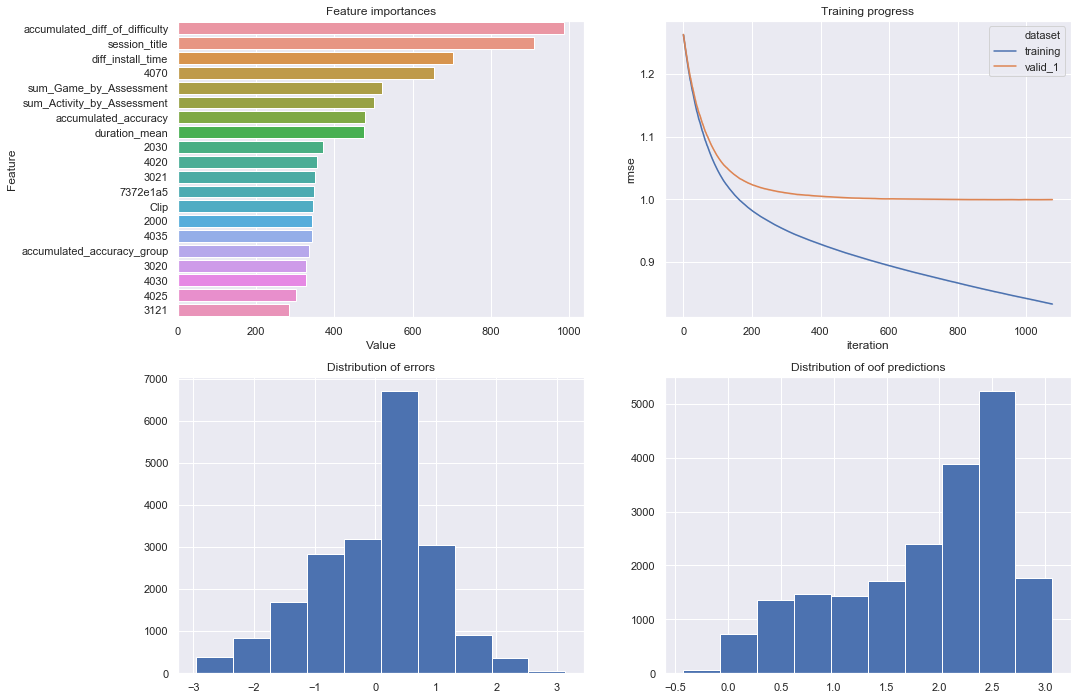

In [13]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
#     'eval_metric': 'cappa',
    'n_jobs': -1,
    'seed': 42,
    'early_stopping_rounds': 100,
    'n_estimators': 2000,
#     'learning_rate': LGB_BO.max['params']['learning_rate'],
#     'max_depth': int(LGB_BO.max['params']['max_depth']),
#     'lambda_l1': LGB_BO.max['params']['lambda_l1'],
#     'lambda_l2': LGB_BO.max['params']['lambda_l2'],
#     'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
#     'bagging_freq': int(LGB_BO.max['params']['bagging_freq']),
#     'colsample_bytree': LGB_BO.max['params']['colsample_bytree'],
    'verbose': 10
}
# features = [col for col in reduce_train.columns if not col in ('game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate')]
lgb_model = Lgb_Model(reduce_train, reduce_test, features, categoricals, ps=params)

# Blend and sumbit

In [49]:
train_pred = lgb_model.oof_pred
train_y = reduce_train['accuracy_group']

optimizer = OptimizedKappaRounder(train_pred, train_y, [0, 1, 2, 3])
opt_y_pred = optimizer.predict(lgb_model.y_pred)
opt_oof_pred = optimizer.predict(train_pred)
print(cohen_kappa_score(train_y, opt_oof_pred, weights='quadratic'))

In [39]:
# coefficients = optimizer.coef['x']
# print(coefficients)
coefficients = [1.0104323  1.67378703 2.20458875]

[1.0104323  1.67378703 2.20458875]


In [42]:
preds = lgb_model.y_pred

preds[preds <= coefficients[0]] = 0
preds[np.where(np.logical_and(preds > coefficients[0], preds <= coefficients[1]))] = 1
preds[np.where(np.logical_and(preds > coefficients[1], preds <= coefficients[2]))] = 2
preds[preds > coefficients[2]] = 3

In [47]:
np.unique(preds, return_counts=True)

(array([0., 1., 2., 3.]), array([156, 144, 240, 460]))

In [ ]:
sample_submission['accuracy_group'] = preds.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission['accuracy_group'].value_counts(normalize=True)